# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=False)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*0.001
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.301193, Accuracy: 10.55
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.274040, Accuracy: 14.84
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.257815, Accuracy: 14.84
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.163489, Accuracy: 19.53
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.097618, Accuracy: 19.53
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.152094, Accuracy: 15.62
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.039699, Accuracy: 19.53
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.131342, Accuracy: 14.45
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.124919, Accuracy: 17.58
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.064013, Accuracy: 19.53
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.930942, Accuracy: 23.05
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.961560, Accuracy: 26.95
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.980557, Accuracy: 26.56
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.944812, Accuracy: 19.92
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.931976, Accuracy: 22.66
Train Epoc

Train Epoch: 2 [10240/50000 (23%)]	Loss: 1.268941, Accuracy: 52.34
Train Epoch: 2 [11520/50000 (26%)]	Loss: 1.440852, Accuracy: 44.14
Train Epoch: 2 [12800/50000 (28%)]	Loss: 1.294158, Accuracy: 55.47
Train Epoch: 2 [14080/50000 (31%)]	Loss: 1.355804, Accuracy: 49.61
Train Epoch: 2 [15360/50000 (34%)]	Loss: 1.232116, Accuracy: 52.73
Train Epoch: 2 [16640/50000 (37%)]	Loss: 1.285009, Accuracy: 48.83
Train Epoch: 2 [17920/50000 (40%)]	Loss: 1.357522, Accuracy: 50.78
Train Epoch: 2 [19200/50000 (43%)]	Loss: 1.394781, Accuracy: 46.09
Train Epoch: 2 [20480/50000 (45%)]	Loss: 1.265616, Accuracy: 53.12
Train Epoch: 2 [21760/50000 (48%)]	Loss: 1.382380, Accuracy: 50.00
Train Epoch: 2 [23040/50000 (51%)]	Loss: 1.270823, Accuracy: 50.39
Train Epoch: 2 [24320/50000 (54%)]	Loss: 1.230937, Accuracy: 54.30
Train Epoch: 2 [25600/50000 (57%)]	Loss: 1.280296, Accuracy: 50.78
Train Epoch: 2 [26880/50000 (60%)]	Loss: 1.283794, Accuracy: 49.61
Train Epoch: 2 [28160/50000 (62%)]	Loss: 1.218260, Accuracy: 5

Train Epoch: 5 [23040/50000 (51%)]	Loss: 0.923117, Accuracy: 67.19
Train Epoch: 5 [24320/50000 (54%)]	Loss: 0.886234, Accuracy: 69.14
Train Epoch: 5 [25600/50000 (57%)]	Loss: 0.808614, Accuracy: 71.48
Train Epoch: 5 [26880/50000 (60%)]	Loss: 0.682829, Accuracy: 74.61
Train Epoch: 5 [28160/50000 (62%)]	Loss: 0.796256, Accuracy: 73.83
Train Epoch: 5 [29440/50000 (65%)]	Loss: 0.816920, Accuracy: 72.27
Train Epoch: 5 [30720/50000 (68%)]	Loss: 0.984813, Accuracy: 65.23
Train Epoch: 5 [32000/50000 (71%)]	Loss: 0.744702, Accuracy: 73.83
Train Epoch: 5 [33280/50000 (74%)]	Loss: 0.906883, Accuracy: 68.36
Train Epoch: 5 [34560/50000 (77%)]	Loss: 0.776176, Accuracy: 74.61
Train Epoch: 5 [35840/50000 (80%)]	Loss: 0.632492, Accuracy: 78.91
Train Epoch: 5 [37120/50000 (82%)]	Loss: 0.660754, Accuracy: 78.12
Train Epoch: 5 [38400/50000 (85%)]	Loss: 0.704794, Accuracy: 74.61
Train Epoch: 5 [39680/50000 (88%)]	Loss: 0.693226, Accuracy: 75.39
Train Epoch: 5 [40960/50000 (91%)]	Loss: 0.893316, Accuracy: 6

Train Epoch: 8 [35840/50000 (80%)]	Loss: 0.681434, Accuracy: 76.17
Train Epoch: 8 [37120/50000 (82%)]	Loss: 0.605318, Accuracy: 78.52
Train Epoch: 8 [38400/50000 (85%)]	Loss: 0.565794, Accuracy: 82.81
Train Epoch: 8 [39680/50000 (88%)]	Loss: 0.811403, Accuracy: 75.39
Train Epoch: 8 [40960/50000 (91%)]	Loss: 0.689579, Accuracy: 77.34
Train Epoch: 8 [42240/50000 (94%)]	Loss: 0.600404, Accuracy: 81.25
Train Epoch: 8 [43520/50000 (97%)]	Loss: 0.541615, Accuracy: 83.59
Train Epoch: 8 [35000/50000 (99%)]	Loss: 0.513571, Accuracy: 83.00

Validation set: Average loss: 0.7000, Accuracy: 3800/5000 (76.00%)

the time of this epoch:[36.16659426689148 s]
Train Epoch: 9 [0/50000 (0%)]	Loss: 0.634978, Accuracy: 78.52
Train Epoch: 9 [1280/50000 (3%)]	Loss: 0.670998, Accuracy: 75.78
Train Epoch: 9 [2560/50000 (6%)]	Loss: 0.705734, Accuracy: 74.61
Train Epoch: 9 [3840/50000 (9%)]	Loss: 0.674797, Accuracy: 75.00
Train Epoch: 9 [5120/50000 (11%)]	Loss: 0.652562, Accuracy: 77.73
Train Epoch: 9 [6400/50000 

Train Epoch: 9 [26880/50000 (60%)]	Loss: 0.636618, Accuracy: 73.44
Train Epoch: 9 [28160/50000 (62%)]	Loss: 0.603979, Accuracy: 79.30
Train Epoch: 9 [29440/50000 (65%)]	Loss: 0.581936, Accuracy: 80.86
Train Epoch: 9 [30720/50000 (68%)]	Loss: 0.621160, Accuracy: 77.73
Train Epoch: 9 [32000/50000 (71%)]	Loss: 0.486165, Accuracy: 82.03
Train Epoch: 9 [33280/50000 (74%)]	Loss: 0.628334, Accuracy: 77.73
Train Epoch: 9 [34560/50000 (77%)]	Loss: 0.511625, Accuracy: 82.81
Train Epoch: 9 [35840/50000 (80%)]	Loss: 0.694919, Accuracy: 77.73
Train Epoch: 9 [37120/50000 (82%)]	Loss: 0.591921, Accuracy: 80.08
Train Epoch: 9 [38400/50000 (85%)]	Loss: 0.600055, Accuracy: 78.91
Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.464070, Accuracy: 84.38
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.555240, Accuracy: 81.25
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.645914, Accuracy: 76.56
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.613458, Accuracy: 79.30
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.553413, Accuracy: 8

Train Epoch: 11 [38400/50000 (85%)]	Loss: 0.557961, Accuracy: 81.25
Train Epoch: 11 [39680/50000 (88%)]	Loss: 0.525491, Accuracy: 80.47
Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.547160, Accuracy: 82.03
Train Epoch: 11 [42240/50000 (94%)]	Loss: 0.519373, Accuracy: 80.47
Train Epoch: 11 [43520/50000 (97%)]	Loss: 0.523677, Accuracy: 80.47
Train Epoch: 11 [35000/50000 (99%)]	Loss: 0.442228, Accuracy: 83.50

Validation set: Average loss: 0.7306, Accuracy: 3796/5000 (75.00%)

the time of this epoch:[39.322229862213135 s]
Train Epoch: 12 [0/50000 (0%)]	Loss: 0.457818, Accuracy: 83.98
Train Epoch: 12 [1280/50000 (3%)]	Loss: 0.488419, Accuracy: 83.20
Train Epoch: 12 [2560/50000 (6%)]	Loss: 0.392485, Accuracy: 87.50
Train Epoch: 12 [3840/50000 (9%)]	Loss: 0.470648, Accuracy: 82.42
Train Epoch: 12 [5120/50000 (11%)]	Loss: 0.470833, Accuracy: 83.98
Train Epoch: 12 [6400/50000 (14%)]	Loss: 0.620533, Accuracy: 79.69
Train Epoch: 12 [7680/50000 (17%)]	Loss: 0.530543, Accuracy: 81.25
Train Epoch: 12


Test set: Average loss: 0.7512, Accuracy: 7579/10000 (75.79%)

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.423116, Accuracy: 86.33
Train Epoch: 15 [1280/50000 (3%)]	Loss: 0.513693, Accuracy: 83.20
Train Epoch: 15 [2560/50000 (6%)]	Loss: 0.417509, Accuracy: 85.94
Train Epoch: 15 [3840/50000 (9%)]	Loss: 0.511564, Accuracy: 83.59
Train Epoch: 15 [5120/50000 (11%)]	Loss: 0.444545, Accuracy: 84.77
Train Epoch: 15 [6400/50000 (14%)]	Loss: 0.504413, Accuracy: 85.16
Train Epoch: 15 [7680/50000 (17%)]	Loss: 0.443434, Accuracy: 83.59
Train Epoch: 15 [8960/50000 (20%)]	Loss: 0.416631, Accuracy: 85.55
Train Epoch: 15 [10240/50000 (23%)]	Loss: 0.461776, Accuracy: 84.77
Train Epoch: 15 [11520/50000 (26%)]	Loss: 0.526470, Accuracy: 83.20
Train Epoch: 15 [12800/50000 (28%)]	Loss: 0.441322, Accuracy: 84.38
Train Epoch: 15 [14080/50000 (31%)]	Loss: 0.624074, Accuracy: 78.12
Train Epoch: 15 [15360/50000 (34%)]	Loss: 0.370835, Accuracy: 88.28
Train Epoch: 15 [16640/50000 (37%)]	Loss: 0.453383, Accuracy: 85.94

Train Epoch: 15 [33280/50000 (74%)]	Loss: 0.472764, Accuracy: 81.64
Train Epoch: 15 [34560/50000 (77%)]	Loss: 0.433955, Accuracy: 85.94
Train Epoch: 15 [35840/50000 (80%)]	Loss: 0.556304, Accuracy: 79.30
Train Epoch: 15 [37120/50000 (82%)]	Loss: 0.495315, Accuracy: 84.38
Train Epoch: 15 [38400/50000 (85%)]	Loss: 0.396428, Accuracy: 85.55
Train Epoch: 15 [39680/50000 (88%)]	Loss: 0.367064, Accuracy: 87.50
Train Epoch: 15 [40960/50000 (91%)]	Loss: 0.399647, Accuracy: 87.11
Train Epoch: 15 [42240/50000 (94%)]	Loss: 0.470434, Accuracy: 85.55
Train Epoch: 15 [43520/50000 (97%)]	Loss: 0.289870, Accuracy: 91.80
Train Epoch: 15 [35000/50000 (99%)]	Loss: 0.583513, Accuracy: 81.50

Validation set: Average loss: 0.6960, Accuracy: 3876/5000 (77.00%)

the time of this epoch:[39.283854246139526 s]
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.441908, Accuracy: 86.33
Train Epoch: 16 [1280/50000 (3%)]	Loss: 0.380697, Accuracy: 87.11
Train Epoch: 16 [2560/50000 (6%)]	Loss: 0.424569, Accuracy: 87.50
Train Epoc

Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.398250, Accuracy: 87.50
Train Epoch: 18 [35000/50000 (99%)]	Loss: 0.470724, Accuracy: 82.00

Validation set: Average loss: 0.7443, Accuracy: 3763/5000 (75.00%)

the time of this epoch:[36.075855016708374 s]

Test set: Average loss: 0.7818, Accuracy: 7476/10000 (74.76%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.481649, Accuracy: 83.98
Train Epoch: 19 [1280/50000 (3%)]	Loss: 0.391837, Accuracy: 87.50
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.396251, Accuracy: 86.33
Train Epoch: 19 [3840/50000 (9%)]	Loss: 0.333600, Accuracy: 87.89
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.458416, Accuracy: 83.20
Train Epoch: 19 [6400/50000 (14%)]	Loss: 0.513920, Accuracy: 83.59
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.474763, Accuracy: 85.94
Train Epoch: 19 [8960/50000 (20%)]	Loss: 0.379429, Accuracy: 86.33
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.554761, Accuracy: 79.69
Train Epoch: 19 [11520/50000 (26%)]	Loss: 0.434848, Accuracy: 85.55
Train Epoch: 19 [128

Train Epoch: 21 [34560/50000 (77%)]	Loss: 0.502543, Accuracy: 82.81
Train Epoch: 21 [35840/50000 (80%)]	Loss: 0.364508, Accuracy: 89.06
Train Epoch: 21 [37120/50000 (82%)]	Loss: 0.445167, Accuracy: 84.38
Train Epoch: 21 [38400/50000 (85%)]	Loss: 0.433231, Accuracy: 86.33
Train Epoch: 21 [39680/50000 (88%)]	Loss: 0.462606, Accuracy: 82.42
Train Epoch: 21 [40960/50000 (91%)]	Loss: 0.444421, Accuracy: 85.55
Train Epoch: 21 [42240/50000 (94%)]	Loss: 0.542456, Accuracy: 82.81
Train Epoch: 21 [43520/50000 (97%)]	Loss: 0.370226, Accuracy: 87.89
Train Epoch: 21 [35000/50000 (99%)]	Loss: 0.482198, Accuracy: 80.00

Validation set: Average loss: 0.9567, Accuracy: 3471/5000 (69.00%)

the time of this epoch:[39.394529819488525 s]
Train Epoch: 22 [0/50000 (0%)]	Loss: 0.574803, Accuracy: 82.42
Train Epoch: 22 [1280/50000 (3%)]	Loss: 0.506914, Accuracy: 83.98
Train Epoch: 22 [2560/50000 (6%)]	Loss: 0.400500, Accuracy: 87.11
Train Epoch: 22 [3840/50000 (9%)]	Loss: 0.396035, Accuracy: 85.94
Train Epoch:

Train Epoch: 24 [26880/50000 (60%)]	Loss: 0.403995, Accuracy: 87.50
Train Epoch: 24 [28160/50000 (62%)]	Loss: 0.421005, Accuracy: 86.33
Train Epoch: 24 [29440/50000 (65%)]	Loss: 0.650298, Accuracy: 79.30
Train Epoch: 24 [30720/50000 (68%)]	Loss: 0.405369, Accuracy: 84.77
Train Epoch: 24 [32000/50000 (71%)]	Loss: 0.496990, Accuracy: 82.81
Train Epoch: 24 [33280/50000 (74%)]	Loss: 0.388477, Accuracy: 88.67
Train Epoch: 24 [34560/50000 (77%)]	Loss: 0.514684, Accuracy: 82.81
Train Epoch: 24 [35840/50000 (80%)]	Loss: 0.420022, Accuracy: 85.16
Train Epoch: 24 [37120/50000 (82%)]	Loss: 0.360726, Accuracy: 88.28
Train Epoch: 24 [38400/50000 (85%)]	Loss: 0.418879, Accuracy: 85.55
Train Epoch: 24 [39680/50000 (88%)]	Loss: 0.444179, Accuracy: 86.72
Train Epoch: 24 [40960/50000 (91%)]	Loss: 0.408781, Accuracy: 86.33
Train Epoch: 24 [42240/50000 (94%)]	Loss: 0.482041, Accuracy: 82.03
Train Epoch: 24 [43520/50000 (97%)]	Loss: 0.398640, Accuracy: 86.33
Train Epoch: 24 [35000/50000 (99%)]	Loss: 0.4011

Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.447819, Accuracy: 84.77
Train Epoch: 25 [14080/50000 (31%)]	Loss: 0.425154, Accuracy: 86.72
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.400745, Accuracy: 85.55
Train Epoch: 25 [16640/50000 (37%)]	Loss: 0.384207, Accuracy: 85.55
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.336324, Accuracy: 87.11
Train Epoch: 25 [19200/50000 (43%)]	Loss: 0.362804, Accuracy: 88.67
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.398884, Accuracy: 85.16
Train Epoch: 25 [21760/50000 (48%)]	Loss: 0.420820, Accuracy: 86.33
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.406062, Accuracy: 84.77
Train Epoch: 25 [24320/50000 (54%)]	Loss: 0.479817, Accuracy: 83.20
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.401292, Accuracy: 86.72
Train Epoch: 25 [26880/50000 (60%)]	Loss: 0.399073, Accuracy: 87.11
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.407654, Accuracy: 87.50
Train Epoch: 25 [29440/50000 (65%)]	Loss: 0.410581, Accuracy: 86.33
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.4377

Train Epoch: 28 [23040/50000 (51%)]	Loss: 0.441940, Accuracy: 86.72
Train Epoch: 28 [24320/50000 (54%)]	Loss: 0.585834, Accuracy: 81.25
Train Epoch: 28 [25600/50000 (57%)]	Loss: 0.375028, Accuracy: 85.94
Train Epoch: 28 [26880/50000 (60%)]	Loss: 0.458805, Accuracy: 85.16
Train Epoch: 28 [28160/50000 (62%)]	Loss: 0.407840, Accuracy: 84.77
Train Epoch: 28 [29440/50000 (65%)]	Loss: 0.434524, Accuracy: 84.38
Train Epoch: 28 [30720/50000 (68%)]	Loss: 0.456318, Accuracy: 84.77
Train Epoch: 28 [32000/50000 (71%)]	Loss: 0.409480, Accuracy: 85.16
Train Epoch: 28 [33280/50000 (74%)]	Loss: 0.343279, Accuracy: 88.67
Train Epoch: 28 [34560/50000 (77%)]	Loss: 0.422610, Accuracy: 85.55
Train Epoch: 28 [35840/50000 (80%)]	Loss: 0.493950, Accuracy: 84.77
Train Epoch: 28 [37120/50000 (82%)]	Loss: 0.423376, Accuracy: 84.77
Train Epoch: 28 [38400/50000 (85%)]	Loss: 0.342945, Accuracy: 91.41
Train Epoch: 28 [39680/50000 (88%)]	Loss: 0.438502, Accuracy: 85.16
Train Epoch: 28 [40960/50000 (91%)]	Loss: 0.4254

Train Epoch: 31 [32000/50000 (71%)]	Loss: 0.456572, Accuracy: 84.77
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.487301, Accuracy: 83.20
Train Epoch: 31 [34560/50000 (77%)]	Loss: 0.394263, Accuracy: 87.89
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.462191, Accuracy: 83.20
Train Epoch: 31 [37120/50000 (82%)]	Loss: 0.446722, Accuracy: 85.94
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.433626, Accuracy: 85.94
Train Epoch: 31 [39680/50000 (88%)]	Loss: 0.437624, Accuracy: 86.72
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.396377, Accuracy: 86.72
Train Epoch: 31 [42240/50000 (94%)]	Loss: 0.404174, Accuracy: 85.55
Train Epoch: 31 [43520/50000 (97%)]	Loss: 0.403128, Accuracy: 85.94
Train Epoch: 31 [35000/50000 (99%)]	Loss: 0.360198, Accuracy: 86.50

Validation set: Average loss: 0.5437, Accuracy: 4104/5000 (82.00%)

the time of this epoch:[39.30496907234192 s]
Train Epoch: 32 [0/50000 (0%)]	Loss: 0.320173, Accuracy: 88.28
Train Epoch: 32 [1280/50000 (3%)]	Loss: 0.310853, Accuracy: 87.50
Train Epo

Train Epoch: 34 [42240/50000 (94%)]	Loss: 0.362900, Accuracy: 87.89
Train Epoch: 34 [43520/50000 (97%)]	Loss: 0.411543, Accuracy: 84.77
Train Epoch: 34 [35000/50000 (99%)]	Loss: 0.402190, Accuracy: 86.50

Validation set: Average loss: 0.7803, Accuracy: 3819/5000 (76.00%)

the time of this epoch:[36.01001310348511 s]

Test set: Average loss: 0.7910, Accuracy: 7710/10000 (77.10%)

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.374204, Accuracy: 87.11
Train Epoch: 35 [1280/50000 (3%)]	Loss: 0.280145, Accuracy: 91.41
Train Epoch: 35 [2560/50000 (6%)]	Loss: 0.356006, Accuracy: 87.89
Train Epoch: 35 [3840/50000 (9%)]	Loss: 0.356838, Accuracy: 88.28
Train Epoch: 35 [5120/50000 (11%)]	Loss: 0.367469, Accuracy: 87.11
Train Epoch: 35 [6400/50000 (14%)]	Loss: 0.414362, Accuracy: 85.55
Train Epoch: 35 [7680/50000 (17%)]	Loss: 0.371691, Accuracy: 85.94
Train Epoch: 35 [8960/50000 (20%)]	Loss: 0.323767, Accuracy: 87.89
Train Epoch: 35 [10240/50000 (23%)]	Loss: 0.379208, Accuracy: 87.11
Train Epoch: 35 [1152

Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.440817, Accuracy: 85.16
Train Epoch: 37 [34560/50000 (77%)]	Loss: 0.391891, Accuracy: 85.94
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.444605, Accuracy: 83.98
Train Epoch: 37 [37120/50000 (82%)]	Loss: 0.335418, Accuracy: 88.28
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.434801, Accuracy: 85.55
Train Epoch: 37 [39680/50000 (88%)]	Loss: 0.452131, Accuracy: 81.25
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.364085, Accuracy: 87.89
Train Epoch: 37 [42240/50000 (94%)]	Loss: 0.347783, Accuracy: 87.89
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.523859, Accuracy: 83.98
Train Epoch: 37 [35000/50000 (99%)]	Loss: 0.462382, Accuracy: 85.50

Validation set: Average loss: 0.7001, Accuracy: 3870/5000 (77.00%)

the time of this epoch:[39.10078692436218 s]
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.347548, Accuracy: 89.06
Train Epoch: 38 [1280/50000 (3%)]	Loss: 0.354613, Accuracy: 89.06
Train Epoch: 38 [2560/50000 (6%)]	Loss: 0.501534, Accuracy: 84.38
Train Epoch

Train Epoch: 40 [43520/50000 (97%)]	Loss: 0.365337, Accuracy: 87.89
Train Epoch: 40 [35000/50000 (99%)]	Loss: 0.393475, Accuracy: 88.00

Validation set: Average loss: 0.4895, Accuracy: 4173/5000 (83.00%)

the time of this epoch:[35.99338674545288 s]

Test set: Average loss: 0.5239, Accuracy: 8291/10000 (82.91%)

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.364800, Accuracy: 87.11
Train Epoch: 41 [1280/50000 (3%)]	Loss: 0.428449, Accuracy: 87.11
Train Epoch: 41 [2560/50000 (6%)]	Loss: 0.427958, Accuracy: 84.77
Train Epoch: 41 [3840/50000 (9%)]	Loss: 0.315465, Accuracy: 89.06
Train Epoch: 41 [5120/50000 (11%)]	Loss: 0.326807, Accuracy: 87.50
Train Epoch: 41 [6400/50000 (14%)]	Loss: 0.383108, Accuracy: 87.50
Train Epoch: 41 [7680/50000 (17%)]	Loss: 0.308429, Accuracy: 91.02
Train Epoch: 41 [8960/50000 (20%)]	Loss: 0.364063, Accuracy: 86.72
Train Epoch: 41 [10240/50000 (23%)]	Loss: 0.262750, Accuracy: 90.23
Train Epoch: 41 [11520/50000 (26%)]	Loss: 0.352279, Accuracy: 88.67
Train Epoch: 41 [1280

Train Epoch: 44 [3840/50000 (9%)]	Loss: 0.346135, Accuracy: 87.50
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.375538, Accuracy: 87.11
Train Epoch: 44 [6400/50000 (14%)]	Loss: 0.360760, Accuracy: 87.11
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.352375, Accuracy: 88.28
Train Epoch: 44 [8960/50000 (20%)]	Loss: 0.312323, Accuracy: 88.67
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.425454, Accuracy: 83.20
Train Epoch: 44 [11520/50000 (26%)]	Loss: 0.345580, Accuracy: 88.67
Train Epoch: 44 [12800/50000 (28%)]	Loss: 0.426057, Accuracy: 83.98
Train Epoch: 44 [14080/50000 (31%)]	Loss: 0.312539, Accuracy: 88.28
Train Epoch: 44 [15360/50000 (34%)]	Loss: 0.414651, Accuracy: 86.72
Train Epoch: 44 [16640/50000 (37%)]	Loss: 0.353871, Accuracy: 88.28
Train Epoch: 44 [17920/50000 (40%)]	Loss: 0.438402, Accuracy: 86.33
Train Epoch: 44 [19200/50000 (43%)]	Loss: 0.436797, Accuracy: 85.55
Train Epoch: 44 [20480/50000 (45%)]	Loss: 0.412772, Accuracy: 86.72
Train Epoch: 44 [21760/50000 (48%)]	Loss: 0.258060, Ac

Train Epoch: 47 [12800/50000 (28%)]	Loss: 0.351939, Accuracy: 89.84
Train Epoch: 47 [14080/50000 (31%)]	Loss: 0.361994, Accuracy: 88.28
Train Epoch: 47 [15360/50000 (34%)]	Loss: 0.381853, Accuracy: 87.50
Train Epoch: 47 [16640/50000 (37%)]	Loss: 0.302289, Accuracy: 91.80
Train Epoch: 47 [17920/50000 (40%)]	Loss: 0.415726, Accuracy: 85.55
Train Epoch: 47 [19200/50000 (43%)]	Loss: 0.358385, Accuracy: 88.67
Train Epoch: 47 [20480/50000 (45%)]	Loss: 0.423656, Accuracy: 85.55
Train Epoch: 47 [21760/50000 (48%)]	Loss: 0.554326, Accuracy: 85.55
Train Epoch: 47 [23040/50000 (51%)]	Loss: 0.454626, Accuracy: 85.94
Train Epoch: 47 [24320/50000 (54%)]	Loss: 0.483670, Accuracy: 83.20
Train Epoch: 47 [25600/50000 (57%)]	Loss: 0.349933, Accuracy: 86.72
Train Epoch: 47 [26880/50000 (60%)]	Loss: 0.368916, Accuracy: 87.11
Train Epoch: 47 [28160/50000 (62%)]	Loss: 0.368349, Accuracy: 88.28
Train Epoch: 47 [29440/50000 (65%)]	Loss: 0.280055, Accuracy: 89.84
Train Epoch: 47 [30720/50000 (68%)]	Loss: 0.3524

Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.341493, Accuracy: 89.45
Train Epoch: 50 [6400/50000 (14%)]	Loss: 0.291443, Accuracy: 89.45
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.388869, Accuracy: 85.94
Train Epoch: 50 [8960/50000 (20%)]	Loss: 0.367073, Accuracy: 87.11
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.321715, Accuracy: 90.62
Train Epoch: 50 [11520/50000 (26%)]	Loss: 0.309315, Accuracy: 89.84
Train Epoch: 50 [12800/50000 (28%)]	Loss: 0.410588, Accuracy: 87.50
Train Epoch: 50 [14080/50000 (31%)]	Loss: 0.337333, Accuracy: 87.50
Train Epoch: 50 [15360/50000 (34%)]	Loss: 0.393458, Accuracy: 83.98
Train Epoch: 50 [16640/50000 (37%)]	Loss: 0.334502, Accuracy: 88.67
Train Epoch: 50 [17920/50000 (40%)]	Loss: 0.351789, Accuracy: 88.67
Train Epoch: 50 [19200/50000 (43%)]	Loss: 0.372586, Accuracy: 86.33
Train Epoch: 50 [20480/50000 (45%)]	Loss: 0.524464, Accuracy: 81.64
Train Epoch: 50 [21760/50000 (48%)]	Loss: 0.377082, Accuracy: 86.33
Train Epoch: 50 [23040/50000 (51%)]	Loss: 0.401462, 

Train Epoch: 53 [14080/50000 (31%)]	Loss: 0.263963, Accuracy: 89.45
Train Epoch: 53 [15360/50000 (34%)]	Loss: 0.208154, Accuracy: 91.80
Train Epoch: 53 [16640/50000 (37%)]	Loss: 0.222489, Accuracy: 91.02
Train Epoch: 53 [17920/50000 (40%)]	Loss: 0.236020, Accuracy: 92.19
Train Epoch: 53 [19200/50000 (43%)]	Loss: 0.215638, Accuracy: 92.58
Train Epoch: 53 [20480/50000 (45%)]	Loss: 0.144391, Accuracy: 96.09
Train Epoch: 53 [21760/50000 (48%)]	Loss: 0.186236, Accuracy: 93.75
Train Epoch: 53 [23040/50000 (51%)]	Loss: 0.142846, Accuracy: 95.31
Train Epoch: 53 [24320/50000 (54%)]	Loss: 0.115034, Accuracy: 96.48
Train Epoch: 53 [25600/50000 (57%)]	Loss: 0.172566, Accuracy: 93.36
Train Epoch: 53 [26880/50000 (60%)]	Loss: 0.117987, Accuracy: 96.88
Train Epoch: 53 [28160/50000 (62%)]	Loss: 0.145040, Accuracy: 94.92
Train Epoch: 53 [29440/50000 (65%)]	Loss: 0.133308, Accuracy: 96.48
Train Epoch: 53 [30720/50000 (68%)]	Loss: 0.197734, Accuracy: 92.97
Train Epoch: 53 [32000/50000 (71%)]	Loss: 0.2665

Train Epoch: 56 [24320/50000 (54%)]	Loss: 0.167938, Accuracy: 94.53
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.196391, Accuracy: 93.75
Train Epoch: 56 [26880/50000 (60%)]	Loss: 0.173906, Accuracy: 94.92
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.118600, Accuracy: 95.31
Train Epoch: 56 [29440/50000 (65%)]	Loss: 0.113974, Accuracy: 96.09
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.112384, Accuracy: 96.09
Train Epoch: 56 [32000/50000 (71%)]	Loss: 0.111794, Accuracy: 96.48
Train Epoch: 56 [33280/50000 (74%)]	Loss: 0.169455, Accuracy: 95.31
Train Epoch: 56 [34560/50000 (77%)]	Loss: 0.127784, Accuracy: 95.70
Train Epoch: 56 [35840/50000 (80%)]	Loss: 0.118911, Accuracy: 96.09
Train Epoch: 56 [37120/50000 (82%)]	Loss: 0.153957, Accuracy: 94.92
Train Epoch: 56 [38400/50000 (85%)]	Loss: 0.120175, Accuracy: 96.88
Train Epoch: 56 [39680/50000 (88%)]	Loss: 0.122445, Accuracy: 94.92
Train Epoch: 56 [40960/50000 (91%)]	Loss: 0.135656, Accuracy: 95.31
Train Epoch: 56 [42240/50000 (94%)]	Loss: 0.1174

Train Epoch: 59 [33280/50000 (74%)]	Loss: 0.187375, Accuracy: 94.53
Train Epoch: 59 [34560/50000 (77%)]	Loss: 0.159135, Accuracy: 93.75
Train Epoch: 59 [35840/50000 (80%)]	Loss: 0.110102, Accuracy: 96.09
Train Epoch: 59 [37120/50000 (82%)]	Loss: 0.113797, Accuracy: 95.70
Train Epoch: 59 [38400/50000 (85%)]	Loss: 0.075195, Accuracy: 97.66
Train Epoch: 59 [39680/50000 (88%)]	Loss: 0.065281, Accuracy: 97.66
Train Epoch: 59 [40960/50000 (91%)]	Loss: 0.097464, Accuracy: 96.88
Train Epoch: 59 [42240/50000 (94%)]	Loss: 0.120686, Accuracy: 96.48
Train Epoch: 59 [43520/50000 (97%)]	Loss: 0.178711, Accuracy: 94.53
Train Epoch: 59 [35000/50000 (99%)]	Loss: 0.077285, Accuracy: 98.00

Validation set: Average loss: 0.2873, Accuracy: 4559/5000 (91.00%)

the time of this epoch:[39.11355900764465 s]
Train Epoch: 60 [0/50000 (0%)]	Loss: 0.131130, Accuracy: 95.31
Train Epoch: 60 [1280/50000 (3%)]	Loss: 0.139323, Accuracy: 95.70
Train Epoch: 60 [2560/50000 (6%)]	Loss: 0.114825, Accuracy: 96.09
Train Epoch

Train Epoch: 62 [43520/50000 (97%)]	Loss: 0.131793, Accuracy: 94.14
Train Epoch: 62 [35000/50000 (99%)]	Loss: 0.164941, Accuracy: 94.00

Validation set: Average loss: 0.2958, Accuracy: 4581/5000 (91.00%)

the time of this epoch:[35.93161964416504 s]

Test set: Average loss: 0.3105, Accuracy: 9091/10000 (90.91%)

Train Epoch: 63 [0/50000 (0%)]	Loss: 0.099413, Accuracy: 96.88
Train Epoch: 63 [1280/50000 (3%)]	Loss: 0.124627, Accuracy: 96.09
Train Epoch: 63 [2560/50000 (6%)]	Loss: 0.133540, Accuracy: 94.53
Train Epoch: 63 [3840/50000 (9%)]	Loss: 0.103924, Accuracy: 95.31
Train Epoch: 63 [5120/50000 (11%)]	Loss: 0.109923, Accuracy: 96.09
Train Epoch: 63 [6400/50000 (14%)]	Loss: 0.074160, Accuracy: 96.88
Train Epoch: 63 [7680/50000 (17%)]	Loss: 0.068707, Accuracy: 97.27
Train Epoch: 63 [8960/50000 (20%)]	Loss: 0.058825, Accuracy: 98.05
Train Epoch: 63 [10240/50000 (23%)]	Loss: 0.097287, Accuracy: 96.48
Train Epoch: 63 [11520/50000 (26%)]	Loss: 0.072210, Accuracy: 98.05
Train Epoch: 63 [1280

Train Epoch: 66 [3840/50000 (9%)]	Loss: 0.074329, Accuracy: 98.05
Train Epoch: 66 [5120/50000 (11%)]	Loss: 0.106755, Accuracy: 96.48
Train Epoch: 66 [6400/50000 (14%)]	Loss: 0.053435, Accuracy: 98.83
Train Epoch: 66 [7680/50000 (17%)]	Loss: 0.036857, Accuracy: 99.22
Train Epoch: 66 [8960/50000 (20%)]	Loss: 0.076275, Accuracy: 96.88
Train Epoch: 66 [10240/50000 (23%)]	Loss: 0.080712, Accuracy: 97.27
Train Epoch: 66 [11520/50000 (26%)]	Loss: 0.083678, Accuracy: 96.88
Train Epoch: 66 [12800/50000 (28%)]	Loss: 0.088594, Accuracy: 96.88
Train Epoch: 66 [14080/50000 (31%)]	Loss: 0.088256, Accuracy: 97.66
Train Epoch: 66 [15360/50000 (34%)]	Loss: 0.085002, Accuracy: 98.05
Train Epoch: 66 [16640/50000 (37%)]	Loss: 0.106257, Accuracy: 96.88
Train Epoch: 66 [17920/50000 (40%)]	Loss: 0.080638, Accuracy: 96.88
Train Epoch: 66 [19200/50000 (43%)]	Loss: 0.084765, Accuracy: 96.09
Train Epoch: 66 [20480/50000 (45%)]	Loss: 0.090744, Accuracy: 96.09
Train Epoch: 66 [21760/50000 (48%)]	Loss: 0.072807, Ac

Train Epoch: 69 [6400/50000 (14%)]	Loss: 0.091828, Accuracy: 95.70
Train Epoch: 69 [7680/50000 (17%)]	Loss: 0.074907, Accuracy: 97.27
Train Epoch: 69 [8960/50000 (20%)]	Loss: 0.056986, Accuracy: 97.27
Train Epoch: 69 [10240/50000 (23%)]	Loss: 0.072370, Accuracy: 96.88
Train Epoch: 69 [11520/50000 (26%)]	Loss: 0.067871, Accuracy: 97.66
Train Epoch: 69 [12800/50000 (28%)]	Loss: 0.082480, Accuracy: 96.88
Train Epoch: 69 [14080/50000 (31%)]	Loss: 0.111496, Accuracy: 95.31
Train Epoch: 69 [15360/50000 (34%)]	Loss: 0.069989, Accuracy: 98.44
Train Epoch: 69 [16640/50000 (37%)]	Loss: 0.115362, Accuracy: 96.88
Train Epoch: 69 [17920/50000 (40%)]	Loss: 0.028559, Accuracy: 99.22
Train Epoch: 69 [19200/50000 (43%)]	Loss: 0.064612, Accuracy: 98.05
Train Epoch: 69 [20480/50000 (45%)]	Loss: 0.067728, Accuracy: 98.05
Train Epoch: 69 [21760/50000 (48%)]	Loss: 0.067078, Accuracy: 97.27
Train Epoch: 69 [23040/50000 (51%)]	Loss: 0.094225, Accuracy: 97.66
Train Epoch: 69 [24320/50000 (54%)]	Loss: 0.128047,

Train Epoch: 72 [8960/50000 (20%)]	Loss: 0.027470, Accuracy: 99.61
Train Epoch: 72 [10240/50000 (23%)]	Loss: 0.057915, Accuracy: 98.05
Train Epoch: 72 [11520/50000 (26%)]	Loss: 0.062855, Accuracy: 97.66
Train Epoch: 72 [12800/50000 (28%)]	Loss: 0.023505, Accuracy: 99.61
Train Epoch: 72 [14080/50000 (31%)]	Loss: 0.121330, Accuracy: 94.92
Train Epoch: 72 [15360/50000 (34%)]	Loss: 0.072991, Accuracy: 97.27
Train Epoch: 72 [16640/50000 (37%)]	Loss: 0.033042, Accuracy: 99.22
Train Epoch: 72 [17920/50000 (40%)]	Loss: 0.045857, Accuracy: 98.83
Train Epoch: 72 [19200/50000 (43%)]	Loss: 0.076451, Accuracy: 96.88
Train Epoch: 72 [20480/50000 (45%)]	Loss: 0.044467, Accuracy: 98.83
Train Epoch: 72 [21760/50000 (48%)]	Loss: 0.044116, Accuracy: 98.83
Train Epoch: 72 [23040/50000 (51%)]	Loss: 0.050089, Accuracy: 97.27
Train Epoch: 72 [24320/50000 (54%)]	Loss: 0.032252, Accuracy: 98.83
Train Epoch: 72 [25600/50000 (57%)]	Loss: 0.055172, Accuracy: 98.05
Train Epoch: 72 [26880/50000 (60%)]	Loss: 0.04170

Train Epoch: 73 [16640/50000 (37%)]	Loss: 0.051639, Accuracy: 98.05
Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.064227, Accuracy: 98.44
Train Epoch: 73 [19200/50000 (43%)]	Loss: 0.045274, Accuracy: 99.61
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.037824, Accuracy: 98.44
Train Epoch: 73 [21760/50000 (48%)]	Loss: 0.028323, Accuracy: 99.22
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.079261, Accuracy: 97.27
Train Epoch: 73 [24320/50000 (54%)]	Loss: 0.044296, Accuracy: 98.83
Train Epoch: 73 [25600/50000 (57%)]	Loss: 0.043853, Accuracy: 98.05
Train Epoch: 73 [26880/50000 (60%)]	Loss: 0.061925, Accuracy: 98.83
Train Epoch: 73 [28160/50000 (62%)]	Loss: 0.026606, Accuracy: 99.61
Train Epoch: 73 [29440/50000 (65%)]	Loss: 0.048631, Accuracy: 98.83
Train Epoch: 73 [30720/50000 (68%)]	Loss: 0.041155, Accuracy: 98.05
Train Epoch: 73 [32000/50000 (71%)]	Loss: 0.035399, Accuracy: 98.44
Train Epoch: 73 [33280/50000 (74%)]	Loss: 0.041660, Accuracy: 98.83
Train Epoch: 73 [34560/50000 (77%)]	Loss: 0.0392

Train Epoch: 76 [26880/50000 (60%)]	Loss: 0.053958, Accuracy: 98.44
Train Epoch: 76 [28160/50000 (62%)]	Loss: 0.035521, Accuracy: 99.22
Train Epoch: 76 [29440/50000 (65%)]	Loss: 0.036459, Accuracy: 98.44
Train Epoch: 76 [30720/50000 (68%)]	Loss: 0.041037, Accuracy: 98.83
Train Epoch: 76 [32000/50000 (71%)]	Loss: 0.084030, Accuracy: 96.88
Train Epoch: 76 [33280/50000 (74%)]	Loss: 0.028011, Accuracy: 99.61
Train Epoch: 76 [34560/50000 (77%)]	Loss: 0.030231, Accuracy: 99.61
Train Epoch: 76 [35840/50000 (80%)]	Loss: 0.015004, Accuracy: 100.00
Train Epoch: 76 [37120/50000 (82%)]	Loss: 0.052571, Accuracy: 98.05
Train Epoch: 76 [38400/50000 (85%)]	Loss: 0.038240, Accuracy: 99.61
Train Epoch: 76 [39680/50000 (88%)]	Loss: 0.037129, Accuracy: 98.83
Train Epoch: 76 [40960/50000 (91%)]	Loss: 0.064604, Accuracy: 97.66
Train Epoch: 76 [42240/50000 (94%)]	Loss: 0.030215, Accuracy: 99.61
Train Epoch: 76 [43520/50000 (97%)]	Loss: 0.041718, Accuracy: 98.83
Train Epoch: 76 [35000/50000 (99%)]	Loss: 0.063

Train Epoch: 79 [35840/50000 (80%)]	Loss: 0.044750, Accuracy: 98.44
Train Epoch: 79 [37120/50000 (82%)]	Loss: 0.024068, Accuracy: 99.22
Train Epoch: 79 [38400/50000 (85%)]	Loss: 0.035078, Accuracy: 98.44
Train Epoch: 79 [39680/50000 (88%)]	Loss: 0.058669, Accuracy: 98.83
Train Epoch: 79 [40960/50000 (91%)]	Loss: 0.043991, Accuracy: 98.44
Train Epoch: 79 [42240/50000 (94%)]	Loss: 0.031129, Accuracy: 99.22
Train Epoch: 79 [43520/50000 (97%)]	Loss: 0.033728, Accuracy: 98.44
Train Epoch: 79 [35000/50000 (99%)]	Loss: 0.026831, Accuracy: 98.50

Validation set: Average loss: 0.3024, Accuracy: 4586/5000 (91.00%)

the time of this epoch:[39.23021364212036 s]

Test set: Average loss: 0.3308, Accuracy: 9099/10000 (90.99%)



# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

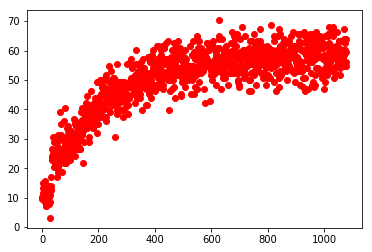

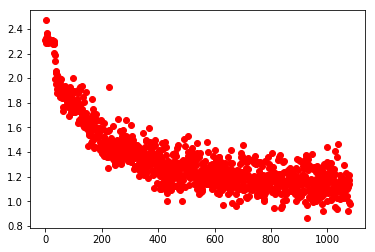

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

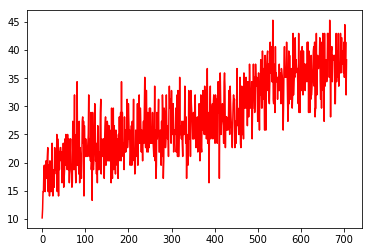

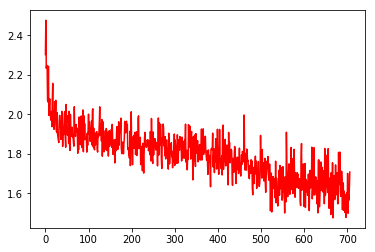

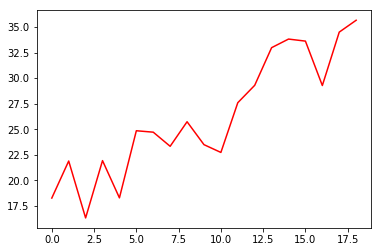

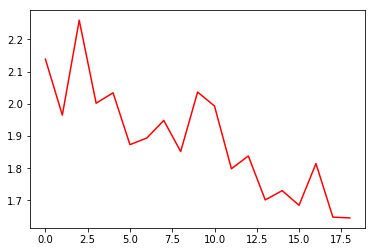

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()